In [6]:
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

#### Load easy dataset - breast cancer

In [7]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer_features_df = pd.DataFrame.from_dict(breast_cancer['data']['features'])
breast_cancer_classes_df = pd.DataFrame.from_dict(breast_cancer['data']['targets'])
pd.concat([breast_cancer_classes_df, breast_cancer_features_df], axis=1)
breast_cancer_classes_df.shape

(569, 1)

In [8]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
X = breast_cancer_features_df
breast_cancer_lb_diagnosis = LabelBinarizer()

y = np.squeeze(breast_cancer_lb_diagnosis.fit_transform(breast_cancer_classes_df))

In [9]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
def evaluate(clf, X, y, scoring=None) -> dict:
    scoring = scoring or ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    _scores = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=8, return_train_score=True)
    return {name: score.mean() for name, score in _scores.items()}

# Iteracyjny Las Losowy (Iterative Random Forest)
Celem jest zbadanie, czy stosowanie Iterative Random Forest, po przez uwzględnienie próbek, które zostały sklasyfikowane błędnie w poprzedniej iteracji, pozwoli na uzyskanie lepszych wyników niż klasyczyny RF.

**IterativeRandomForestClassBased**:
- do kolejnej iteracji ważymy klasy zgodnie z wynikami poprzedniej iteracji $w_{i+1} = 1 - a_i$, gdzie $a_i$ to dokładność  klasyfikacji w iteracji $i$

**IterativeRandomForestSampleBased**:
- do zbioru uczącego dodajemy próbki, które zostały sklasyfikowane błędnie w poprzedniej iteracji


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier

class IterativeRandomForrestClassBased(BaseEstimator):
    def __init__(
            self,
            *,
            iter_count=2,
            n_estimators=2,
            max_depth=None,
    ):

        self.iter_count = 2
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self._fitted_estimator = None

    def _get_estimator(self, weights):
        return RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            n_jobs=8,
            class_weight=weights
        )

    def _get_accuracy_per_class(self, y, y_pred):
        c_matrix = confusion_matrix(y, y_pred)
        return c_matrix.diagonal() / c_matrix.sum(axis=1)
        
    def _get_weights(self, class_accuracies, y):
        unique_classes = np.unique(y)
        weights = {}
        for class_idx, class_accuracy in enumerate(class_accuracies):
            weights[unique_classes[class_idx]] = 1 - class_accuracy
        return weights

    def _get_initial_weights(self, y):
        unique_classes = np.unique(y)
        weights = {}
        for class_name in unique_classes:
            weights[class_name] = 1
        return weights

    def fit(self, X, y):
        weights = self._get_initial_weights(y)
        
        for iteration_idx in range(self.iter_count):
            estimator = self._get_estimator(weights)
            estimator.fit(X, y)
            y_pred = estimator.predict(X)
            class_accuracies = self._get_accuracy_per_class(y, y_pred)
            weights = self._get_weights(class_accuracies, y)
        self._fitted_estimator = estimator
        
    def predict(self, X):
        return self._fitted_estimator.predict(X)
    

In [36]:
NUM_ESTIMATORS = 10
MAX_DEPTH = 2
iteration_counts = list(range(1, 9))
measures = ['accuracy', 'precision', 'recall', 'f1']
res = [evaluate(IterativeRandomForrestClassBased(n_estimators=NUM_ESTIMATORS, max_depth=MAX_DEPTH, iter_count=iter_count), X, y, scoring=measures) for iter_count in iteration_counts]

res_ref_single = evaluate(RandomForestClassifier(
    max_depth=MAX_DEPTH,
    n_estimators=NUM_ESTIMATORS,
    n_jobs=8
), X, y, scoring=measures)
res_ref = [res_ref_single] * len(iteration_counts)


accuracy
precision
recall
f1


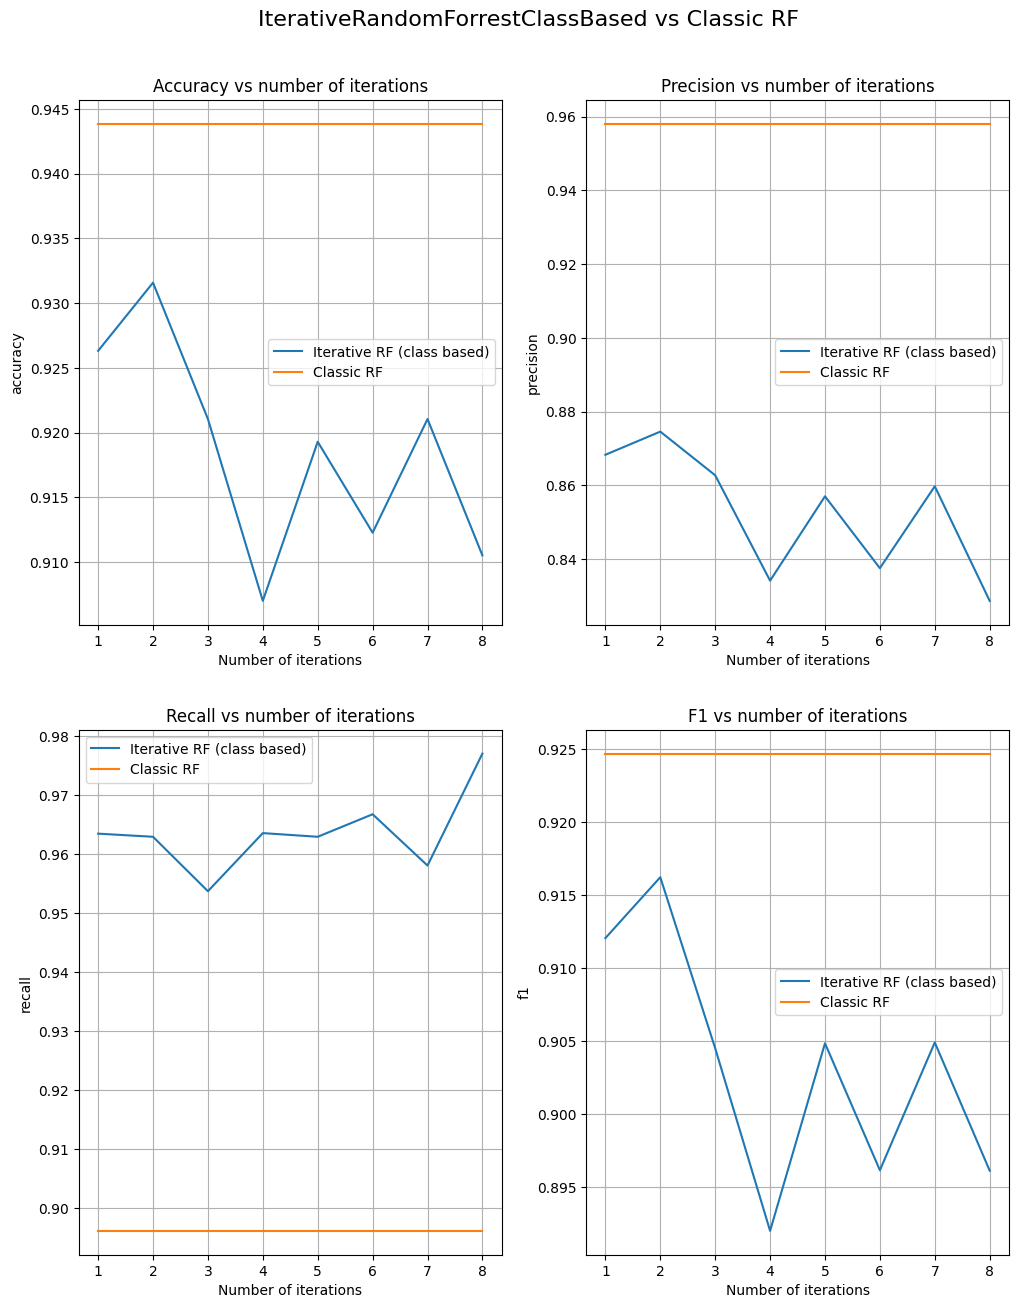

In [37]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    print(measure)
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    ax.plot(iteration_counts, _y, label="Iterative RF (class based)")
    ax.plot(iteration_counts, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of iterations")
    

fig.suptitle("IterativeRandomForrestClassBased vs Classic RF", fontsize=16, y=0.94)
    

plt.show()

In [29]:
class IterativeRandomForrestSampleBased(BaseEstimator):
    def __init__(
            self,
            *,
            iter_count=2,
            n_estimators=2,
            max_depth=None,
    ):

        self.iter_count = iter_count
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self._fitted_estimator = None

    def _get_estimator(self):
        return RandomForestClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            n_jobs=8
        )


    def fit(self, X, y):
        for iteration_idx in range(self.iter_count):
            estimator = self._get_estimator()
            estimator.fit(X, y)
            y_pred = estimator.predict(X)
            misclassified_samples = np.where(y_pred != y)[0]
            X = pd.concat([X, X.iloc[misclassified_samples]])
            y = np.concatenate([y, y[misclassified_samples]])
            
        self._fitted_estimator = estimator
        
    def get_fiited_estimator(self):
        return self._fitted_estimator

In [32]:
NUM_ESTIMATORS = 10
MAX_DEPTH = 2
iteration_counts = list(range(1, 21))
measures = ['accuracy', 'precision', 'recall', 'f1']

itertative_rfs = []
for iter_count in iteration_counts:
    clf = IterativeRandomForrestSampleBased(n_estimators=NUM_ESTIMATORS, max_depth=MAX_DEPTH, iter_count=iter_count)
    clf.fit(X, y)
    itertative_rfs.append(clf.get_fiited_estimator())

res = [evaluate(itertative_rfs[idx], X, y, scoring=measures) for idx, iter_count in enumerate(iteration_counts)]

res_ref_single = evaluate(RandomForestClassifier(
    max_depth=MAX_DEPTH,
    n_estimators=NUM_ESTIMATORS,
    n_jobs=8
), X, y, scoring=measures)
res_ref = [res_ref_single] * len(iteration_counts)

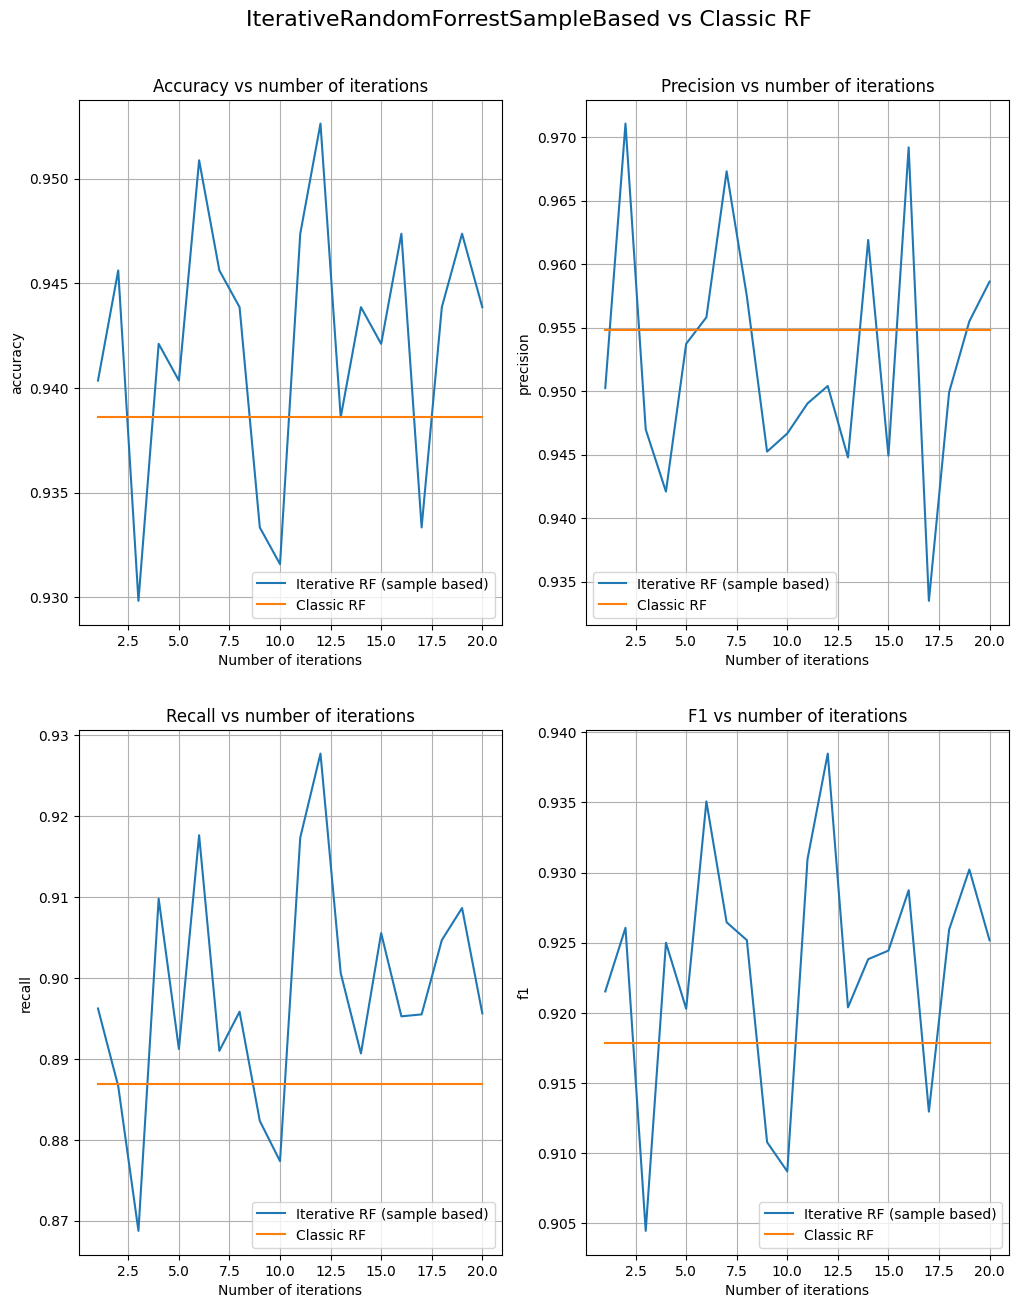

In [34]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    ax.plot(iteration_counts, _y, label="Iterative RF (sample based)")
    ax.plot(iteration_counts, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of iterations")
    

fig.suptitle("IterativeRandomForrestSampleBased vs Classic RF", fontsize=16, y=0.94)
    

plt.show()

#### Load hard dataset - statlog german credit data

In [38]:
from ucimlrepo import fetch_ucirepo

statlog_german_credit_data = fetch_ucirepo(id=144)


from sklearn.preprocessing import LabelEncoder, LabelBinarizer

statlog_german_credit_data_df = pd.DataFrame.from_dict(statlog_german_credit_data.data.features)
statlog_german_credit_data_df['class'] = statlog_german_credit_data.data.targets['class']
statlog_german_credit_data_df['class'] = statlog_german_credit_data_df['class'].astype(str)

encoded_features = statlog_german_credit_data_df.columns
label_encoders = {feature: LabelEncoder() for feature in encoded_features}
for feature, encoder in label_encoders.items():
    statlog_german_credit_data_df[feature] = encoder.fit_transform(statlog_german_credit_data_df[feature])

X = statlog_german_credit_data_df.drop(['class'], axis='columns')
y = statlog_german_credit_data_df['class']

accuracy
precision
recall
f1


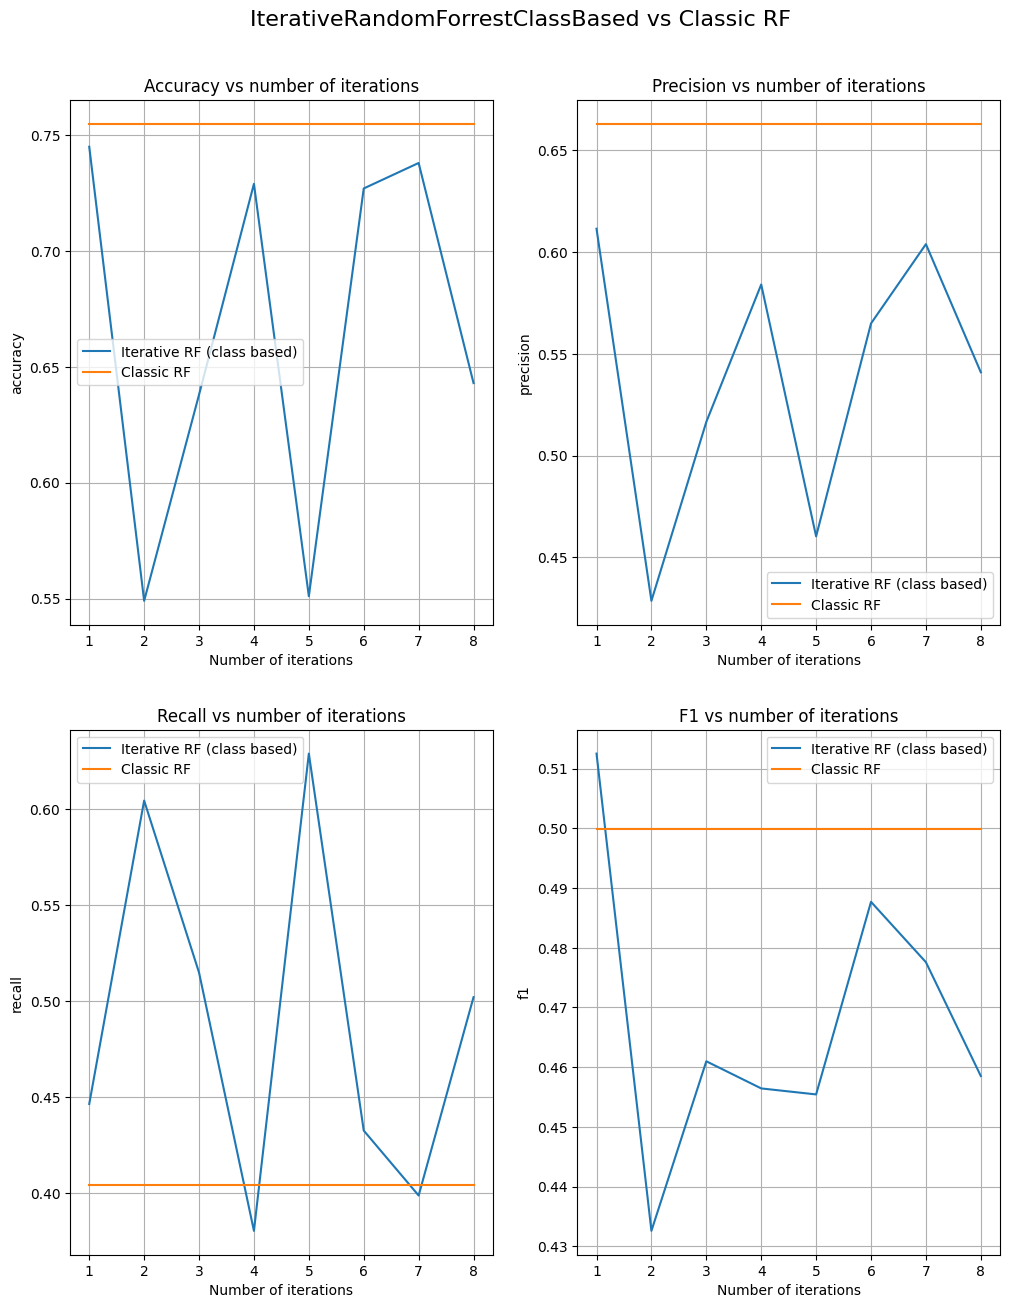

In [41]:
NUM_ESTIMATORS = 10
MAX_DEPTH = 15
iteration_counts = list(range(1, 9))
measures = ['accuracy', 'precision', 'recall', 'f1']
res = [
    evaluate(IterativeRandomForrestClassBased(n_estimators=NUM_ESTIMATORS, max_depth=MAX_DEPTH, iter_count=iter_count),
             X, y, scoring=measures) for iter_count in iteration_counts]

res_ref_single = evaluate(RandomForestClassifier(
    max_depth=MAX_DEPTH,
    n_estimators=NUM_ESTIMATORS,
    n_jobs=8
), X, y, scoring=measures)
res_ref = [res_ref_single] * len(iteration_counts)

from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    print(measure)
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    ax.plot(iteration_counts, _y, label="Iterative RF (class based)")
    ax.plot(iteration_counts, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of iterations")

fig.suptitle("IterativeRandomForrestClassBased vs Classic RF", fontsize=16, y=0.94)

plt.show()

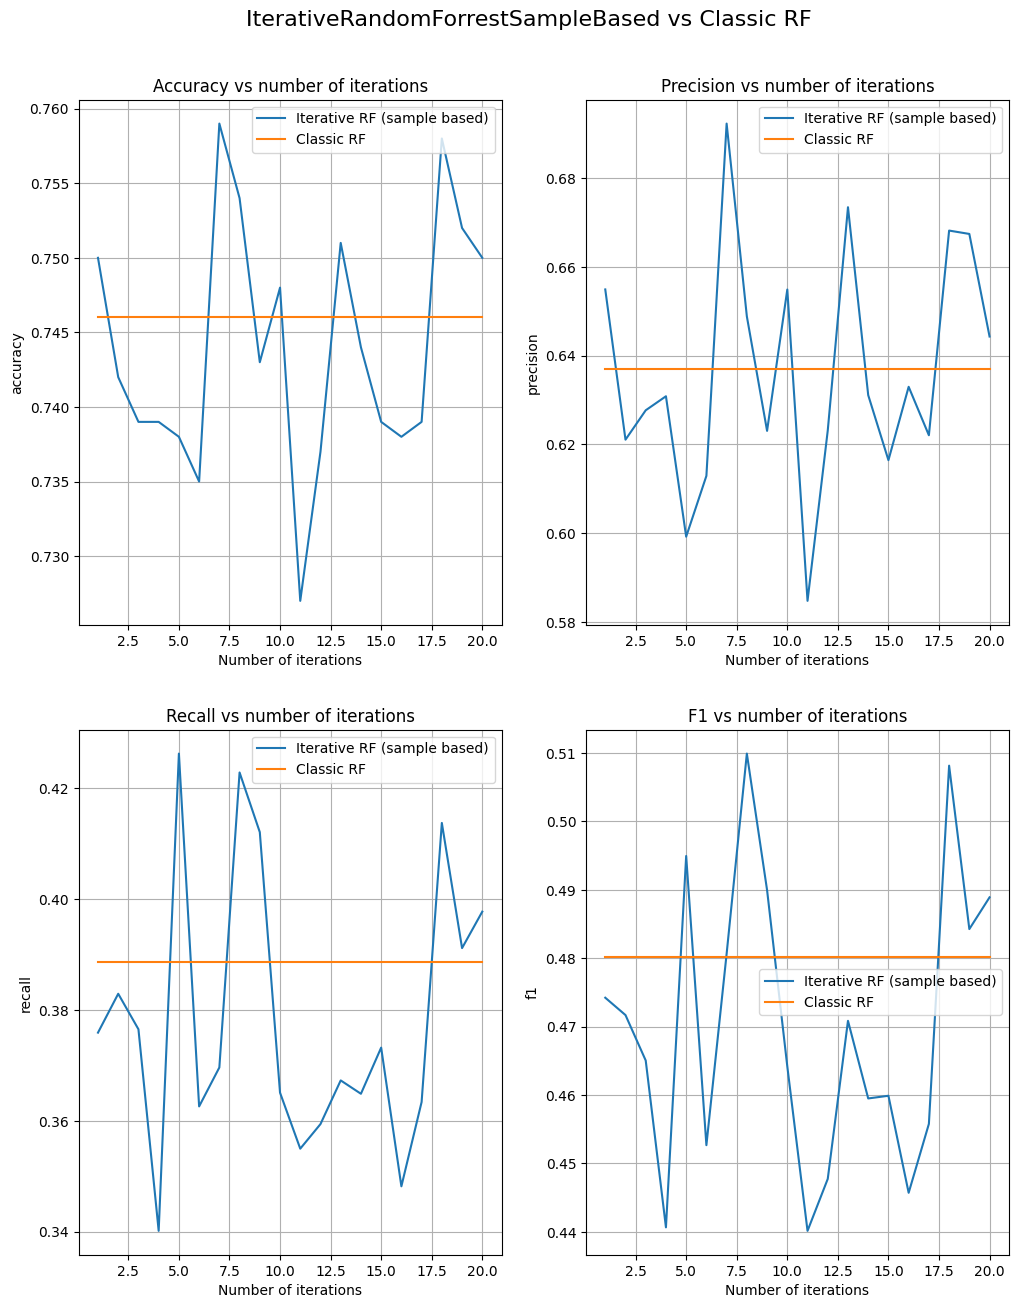

In [42]:
NUM_ESTIMATORS = 10
MAX_DEPTH = 15
iteration_counts = list(range(1, 21))
measures = ['accuracy', 'precision', 'recall', 'f1']

itertative_rfs = []
for iter_count in iteration_counts:
    clf = IterativeRandomForrestSampleBased(n_estimators=NUM_ESTIMATORS, max_depth=MAX_DEPTH, iter_count=iter_count)
    clf.fit(X, y)
    itertative_rfs.append(clf.get_fiited_estimator())

res = [evaluate(itertative_rfs[idx], X, y, scoring=measures) for idx, iter_count in enumerate(iteration_counts)]

res_ref_single = evaluate(RandomForestClassifier(
    max_depth=MAX_DEPTH,
    n_estimators=NUM_ESTIMATORS,
    n_jobs=8
), X, y, scoring=measures)
res_ref = [res_ref_single] * len(iteration_counts)
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res]
    _y_ref = [r[f"test_{measure}"] for r in res_ref]
    ax.plot(iteration_counts, _y, label="Iterative RF (sample based)")
    ax.plot(iteration_counts, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of iterations")

fig.suptitle("IterativeRandomForrestSampleBased vs Classic RF", fontsize=16, y=0.94)

plt.show()

# Wnioski
**IterativeRandomForrestClassBased**:
- RF oparty na ważeniu klas w kolejnych iteracjach osiąga gorzej wyniki niż klasyczny RF, prawdopodobnie ze względu na to, że w kolejnych iteracjach, poprawnie sklasyfikowane próbki mają dostecznenego wpływ
- można zaobserwować ciekawe zjawisko w związku z zmianą metryk Odzysk i Precyzja, na korzyść Odzysku, z stratą Precyzji - model jest w stanie odzyskać więcej próbek, ale kosztem większej liczby fałszywie sklasyfikowanych próbek, co raz chętniej klasyfikuje próbki jako pozytywne z powodu ważenia klas


**IterativeRandomForrestSampleBased**:
- RF oparty na dodawaniu próbek do zbioru uczącego w kolejnych iteracjach osiąga na ogół lepsze wyniki niż klasyczny RF, prawdopodobnie ze względu na to, że w kolejnych iteracjach, douczanue na pozywtny wynik, jako dalsze prace można wykonać próbę porównia z klasycznym RF ale z większą liczbą drzew lub większą głębokością drzew 